<h1>Hawkes EM Learner</h1>
Uses an EM (parametric estimator) kernel to model the source distribution. This attempts to model the data directly, peforming no preprocessing.

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup/Data Loading</h2>

In [1]:
from tick.plot import plot_hawkes_kernels, plot_point_process
from tick.hawkes import SimuHawkesExpKernels, SimuHawkesMulti, HawkesExpKern, SimuHawkes, HawkesEM, HawkesKernelTimeFunc
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

c:\users\ricard grace\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#variables
sec = 1000000000
c_id = 4 #client
ksize = 72 #number of points the kernel should consider
tsize = 36 #time the kernel should consider

X = pd.read_csv('data.csv')
X1 = X[(X.client_id == c_id) & (X.from_ds == 0)].time.apply(lambda x:x/sec)
X2 = X[(X.client_id == c_id) & (X.from_ds == 1)].time.apply(lambda x:x/sec)
maxtime = X1.max()
m = X2.max()
if (m > maxtime):
    maxtime = m
print(f"Max Time: {maxtime}")
print(f"Num Points: {len(X1) + len(X2)}")

data = [X1.astype(np.dtype('d')).to_numpy(), X2.astype(np.dtype('d')).to_numpy()]

Max Time: 244608.309583663
Num Points: 284553


<h2>Training</h2>

Launching the solver HawkesEM...
  n_iter  | rel_baseline | rel_kernel
        0 |     8.00e-01 |   8.70e-01
       10 |     2.76e-03 |   7.90e-03
       20 |     2.46e-03 |   1.57e-03
       30 |     1.39e-03 |   5.53e-04
       40 |     6.50e-04 |   2.20e-04
       50 |     3.03e-04 |   1.06e-04
       60 |     1.41e-04 |   6.22e-05
       70 |     6.62e-05 |   4.09e-05
       80 |     3.56e-05 |   2.87e-05
       90 |     2.60e-05 |   2.11e-05
      100 |     2.26e-05 |   1.61e-05
      110 |     1.93e-05 |   1.26e-05
      120 |     1.51e-05 |   1.00e-05
      130 |     1.08e-05 |   8.11e-06
      140 |     7.24e-06 |   6.63e-06
Done solving using HawkesEM in 292.8425364494324 seconds
EM Score: 2.3791998095821567
EM Baseline: [0.05613197 0.0339007 ]


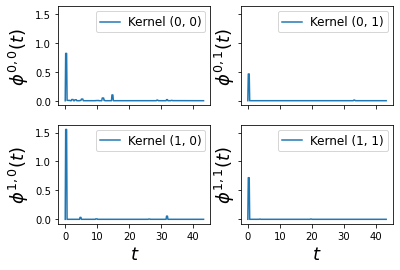

In [3]:
l = 0

#kernel size is the granularity
#kernel support is something... (is it the size of each step?)
em = HawkesEM(kernel_support=tsize, kernel_size=ksize, n_threads=8, verbose=True, tol=1e-5, max_iter=1000)
em.fit(data)

print(f"EM Score: {em.score()}")
print(f"EM Baseline: {em.baseline}")

fig = plot_hawkes_kernels(em)

<h2>Simulation</h2>

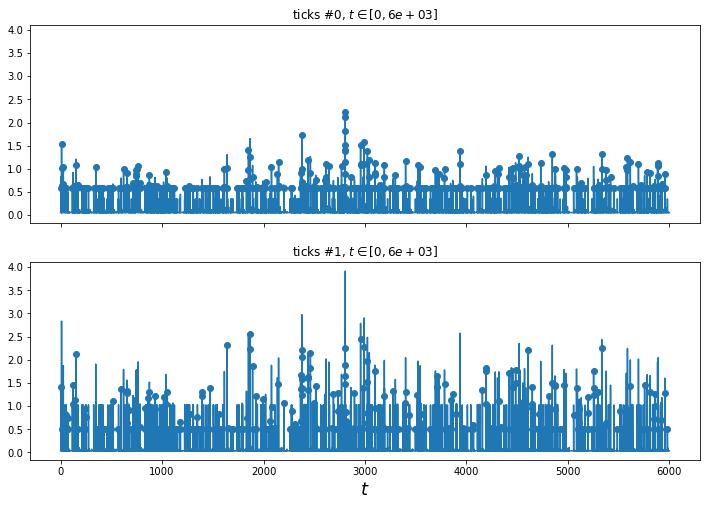

In [4]:
#create the timekernel for simulation
t = np.linspace(0, tsize, endpoint=False, num=ksize)

m = []
for i in range(2):
    for j in range(2):
        m.append(max(em.kernel[i][j]))
spectral_radius = max(m)
if (spectral_radius < 1):
    spectral_radius = 1
        
#create a 2x2 array of time func kernels
k = [[],[]]
for i in range(2):
    for j in range(2):
        k[i].append(HawkesKernelTimeFunc(t_values=t, y_values=em.kernel[i][j]/spectral_radius))
        #spectral radius is just the maximum value?
        #need to keep the values below 1 for a stable process

#simulate the process
hawkes = SimuHawkes(kernels=k, baseline=em.baseline, verbose=False, end_time=6000)

dt = 0.001
hawkes.track_intensity(dt)
hawkes.simulate()

_ = plot_point_process(hawkes, t_max=6000, n_points=1000000)